In [54]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import math
env=gym.make('LunarLander-v2')
print(env.action_space)
print(env.observation_space)
player=1
opponent=-1

Discrete(4)
Box(-inf, inf, (8,), float32)


# MINIMAX AGENT

In [55]:
def isMovesLeft(board):
    for i in range(5):
        for j in range(5):
            if board[i][j]==0:
                return True
    return False

In [56]:
def evaluate(b):
    for i in range(5):
        if b[i][0]==b[i][1] and b[i][1]==b[i][2] and b[i][2]==b[i][3] and b[i][3]==b[i][4]:
            if b[i][0]==player:
                return 10
            elif b[i][0]==opponent:
                return -10
    
    for i in range(5):
        if b[0][i]==b[1][i] and b[1][i]==b[2][i] and b[2][i]==b[3][i] and b[3][i]==b[4][i]:
            if b[0][i]==player:
                return 10
            elif b[0][i]==opponent:
                return -10
    
    if b[0][0] == b[1][1] and b[1][1] == b[2][2] and b[2][2]==b[3][3] and b[3][3]==b[4][4]:
        if b[0][0]==player:
            return 10
        elif b[0][0]==opponent:
            return -10
    
    if b[0][4]==b[1][3] and b[1][3]==b[2][2] and b[2][2]==b[3][1] and b[3][1]==b[4][0]:
        if b[0][4]==player:
            return 10
        elif b[0][4]==opponent:
            return -10
    return 0

In [57]:
def minimax(board,depth,isMax,alpha,beta):
    score=evaluate(board)
    if depth==6:
        return score
    if score==10:
        return score
    
    if score==-10:
        return score
    
    if isMovesLeft(board)==False:
        return 0
    
    if isMax==True:
        best=-1000
        for i in range(5):
            for j in range(5):
                if board[i][j]==0:
                    board[i][j]=player
                    best=max(best,minimax(board,depth+1,False,alpha,beta))
                    board[i][j]=0
                    alpha=max(best,alpha)
                    
                    if beta<=alpha:
                        return best
        return best
    else:
        best=1000
        for i in range(5):
            for j in range(5):
                if board[i][j]==0:
                    board[i][j]=opponent
                    best=min(best,minimax(board,depth+1,True,alpha,beta))
                    board[i][j]=0
                    
                    beta=min(best,beta)
                    
                    if beta<=alpha:
                        return best
        return best

In [58]:
def bestMove(board):
    alpha=-1000
    beta=1000
    bestval=-1000
    besti=-1
    bestj=-1
    
    for i in range(5):
        for j in range(5):
            if board[i][j]==0:
                
                board[i][j]=player
                moveval=minimax(board,0,False,alpha,beta)
                board[i][j]=0
                
                if moveval>bestval:
                    besti=i
                    bestj=j
                    bestval=moveval
#     print("Best move:",besti,bestj)
    return besti,bestj

# Policy Gradient

In [59]:
def convert(num):
    i=math.floor(num/5)
    j=num%5
    
    return i,j

In [71]:
def check(probs,board):
    sortedProbs=probs.argsort()
    for i in reversed(sortedProbs):
        i_index,j_index=convert(i.item())
        if board[i_index][j_index]!=0:
            continue
        else:
            return i

In [72]:
class PolicyNetwork(nn.Module):
    def __init__(self,lr,input_dims,fc1_dims,fc2_dims,n_actions):
        super(PolicyNetwork,self).__init__()
        self.input_dims=input_dims
        self.lr=lr
        self.fc1_dims=fc1_dims
        self.fc2_dims=fc2_dims
        self.n_actions=n_actions
        self.fc1=nn.Linear(input_dims,fc1_dims)
        self.fc2=nn.Linear(fc1_dims,fc2_dims)
        self.fc3=nn.Linear(fc2_dims,n_actions)
        self.optimizer=optim.Adam(self.parameters(),lr=lr)
        
        self.device=T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self,observation):
        observation=T.Tensor(observation).to(self.device)
        x=F.relu(self.fc1(observation))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        
        return x

In [73]:
class Agent():
    def __init__(self,lr,input_dims,gamma=0.99,n_actions=4,l1_size=256,l2_size=256):
        
        self.gamma=gamma
        self.reward_memory=[]
        self.action_memory=[]
        self.policy=PolicyNetwork(lr,input_dims,l1_size,l2_size,n_actions)
        
    def act(self,board):
        probs=F.softmax(self.policy.forward(np.ndarray.flatten(board)))
        action_probs=T.distributions.Categorical(probs)
        action=action_probs.sample()
        i,j=convert(action.item())
        
        if board[i][j]!=0:
            action=check(probs,board)
            
        log_probs=action_probs.log_prob(action)
        self.action_memory.append(log_probs)
        i,j=convert(action.item())
        return i,j
    
    def store_rewards(self,reward):
        self.reward_memory.append(reward)
        
    def learn(self):
        self.policy.optimizer.zero_grad()
        G=[]
        for t in range(len(self.reward_memory)):
            G_sum=0
            discount=1
            
            for k in range(t,len(self.reward_memory)):
                G_sum+=self.reward_memory[k]*discount
                discount*=self.gamma   
            G.append(G_sum)
            
        mean=np.mean(G)
        std=np.std(G) if np.std(G)>0 else 1
        G=np.array(G)
        G=(G-mean)/std
        
        G=T.tensor(G).to(self.policy.device)
        
        loss=0
        
        for g,log_probs in zip(G,self.action_memory):
            loss+= -g*log_probs
        
        loss.backward()
        
        
        self.policy.optimizer.step()
        
        
        self.action_memory=[]
        self.reward_memory=[]
        
        
    

In [77]:
def step(board,i,j):
    board[i][j]=-1
    reward1=evaluate(board)
    if reward1==-10:
        return board,1,True
    besti,bestj=bestMove(board)
    
    board[besti][bestj]=1
    reward2=evaluate(board)
    if reward2==10:
        return board,-1,True
    
    if isMovesLeft(board)==False:
        return board,0.5,True

    return board,0,False

In [80]:
def convBoard(board):
    for i in range(5):
        for j in range(5):
            if board[i][j]==1:
                board[i][j]='X'
            else:
                board[i][j]='O'
    return board

In [82]:

agent=Agent(0.0001,25,0.99,25,25,25)
end=0
score_history=[]
score=0
num_ep=2500

for i in range(num_ep):
    done=False
    score=0
    board=np.zeros((5,5))
    while not done:
        i_index,j_index=agent.act(board)
        board,reward,done=step(board,i_index,j_index)
        agent.store_rewards(reward)
        score+=reward
    score_history.append(score)
    print('episode',i,'score %.3f' % score)
    agent.learn()

/home/neloy/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


episode 0 score -1.000
episode 1 score -1.000
episode 2 score -1.000
episode 3 score 0.500
episode 4 score 0.500
episode 5 score -1.000
episode 6 score 0.500
episode 7 score 0.500
episode 8 score 0.500
episode 9 score -1.000
episode 10 score -1.000
episode 11 score -1.000
episode 12 score -1.000
episode 13 score -1.000
episode 14 score -1.000
episode 15 score 0.500
episode 16 score -1.000
episode 17 score -1.000
episode 18 score 0.500
episode 19 score 0.500
episode 20 score -1.000
episode 21 score 0.500
episode 22 score 0.500
episode 23 score 0.500
episode 24 score 0.500
episode 25 score -1.000
episode 26 score 0.500
episode 27 score -1.000
episode 28 score -1.000
episode 29 score -1.000
episode 30 score -1.000
episode 31 score 0.500
episode 32 score -1.000
episode 33 score -1.000
episode 34 score 0.500
episode 35 score 0.500
episode 36 score 0.500
episode 37 score 0.500
episode 38 score 0.500
episode 39 score -1.000
episode 40 score -1.000
episode 41 score 0.500
episode 42 score 0.500

KeyboardInterrupt: 

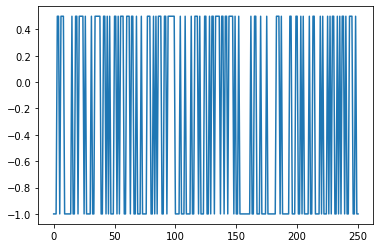

<Figure size 7200x7200 with 0 Axes>

In [90]:
import matplotlib.pyplot as plt
plt.plot(score_history)
plt.show()

In [91]:
print(sum(score_history))

-84.5


In [6]:
#PATH="Model_Weights/lunar_agent1.pt"
# T.save(agent.policy.state_dict(), PATH)

In [7]:
new_agent = Agent(0.0005,8,0.99,4,256,256)
new_agent.policy.load_state_dict(T.load(PATH))
new_agent.policy.eval()

PolicyNetwork(
  (fc1): Linear(in_features=8, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
)

In [12]:

done=False
score=0
observation=env.reset()
while not done:
    action=new_agent.act(observation)
    observation,reward,done,_ =env.step(action)
    env.render()
    score+=reward
# score_history.append(score)
print(score)

/home/neloy/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


70.01457608752972


In [8]:
num=0
convert(num)

(0, 0)

In [41]:
num

0

In [9]:
T.tensor(4)

tensor(4)